In [1]:
save_model = True
load_model = False
train_model = True
save_preprocessing = True #add
load_preprocessing = False #add
save_results = True
predict_train = False
predict_dev = True

run_toy = False
toy_size = 1000
epochs = 3
batch_size = 16
VERSION="train-on-drop-only"
t5_model = 't5-small'

warmup_steps = 10 #1e4
encoder_max_len = 250
decoder_max_len = 54
buffer_size = 1000

# Using T5 on DROP

#### Package installs

#### check gpu

In [2]:
!nvidia-smi

Tue Jul 13 03:17:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P8    50W / 420W |    589MiB / 24265MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Download drop_eval module and set directories

https://github.com/allenai/allennlp-reading-comprehension/blob/master/allennlp_rc/eval/drop_eval.py

In [3]:
!wget https://raw.githubusercontent.com/allenai/allennlp-reading-comprehension/master/allennlp_rc/eval/drop_eval.py -O drop_eval.py

#set directories
import os
if not os.path.exists('./data'):
    !mkdir data
data_dir = f"./data/{VERSION}/{t5_model}"
if not os.path.exists(data_dir):
    !mkdir $data_dir
else:
    if save_model: print(f'!!!!!{VERSION} directory already created locally -- CAUTION -- this run may overwrite existing data!!!!!')
    else: print('NOTE: save_model == FALSE, this execution will not save the model locally')
    
results_dir = f"{data_dir}/results/"
if not os.path.exists(results_dir):
    !mkdir $results_dir

log_dir = f"{data_dir}/experiments/logs"
save_path = f"{data_dir}/experiments/models"


--2021-07-13 03:17:49--  https://raw.githubusercontent.com/allenai/allennlp-reading-comprehension/master/allennlp_rc/eval/drop_eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11222 (11K) [text/plain]
Saving to: ‘drop_eval.py’

drop_eval.py        100%[===================>]  10.96K  --.-KB/s    in 0.007s  

2021-07-13 03:17:50 (1.51 MB/s) - ‘drop_eval.py’ saved [11222/11222]

!!!!!train-on-drop-only directory already created locally -- CAUTION -- this run may overwrite existing data!!!!!


#### set directories

#### load packages

In [4]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')


# import logging
# logging.getLogger("tensorflow").setLevel(logging.ERROR)
# logging.getLogger("tensorflow").addHandler(logging.NullHandler(logging.ERROR))

from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow.keras as keras
import drop_eval
import pandas as pd
import numpy as np
import json
from datasets import Dataset, load_dataset
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm,trange

%load_ext tensorboard

assert len(tf.config.list_physical_devices("GPU")) > 0, "No GPU found by Tensorflow"

if(run_toy): print(f'Running on {toy_size:,} records for development run')
    
!nvcc -V

2021-07-13 03:17:50.511885: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jun__2_19:15:15_PDT_2021
Cuda compilation tools, release 11.4, V11.4.48
Build cuda_11.4.r11.4/compiler.30033411_0


2021-07-13 03:17:51.605305: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-13 03:17:51.616929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-13 03:17:51.617700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-07-13 03:17:51.617715: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-13 03:17:51.619806: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-13 03:17:51.619831: I tensorflow/stream_executor/platform/de

#### Define model class

In [5]:
class T5forDrop(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss') 
    
    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)
        
        self.loss_tracker.update_state(loss)        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}



#### Import model and tokenizer

In [6]:
tokenizer = T5Tokenizer.from_pretrained(t5_model)
#replace numbers with special tokens
numbers = {'additional_special_tokens':['1','2','3','4','5','6','7','8','9','0']}
num_tokens_added = tokenizer.add_special_tokens(numbers)


model = T5forDrop.from_pretrained(t5_model)

2021-07-13 03:17:59.304116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-13 03:17:59.305402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-13 03:17:59.307852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-07-13 03:17:59.307981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1),

#### Import data

In [7]:
def make_toy(dataset,toy_size=1000):
    df = dataset.to_pandas()
    df = df.head(toy_size)
    return Dataset.from_pandas(df)

In [8]:
train_dataset_full = load_dataset('drop', split='train')
valid_dataset_full = load_dataset('drop', split='validation')

print('Dataset features: ',train_dataset_full.features)

#reduce data to toy size if run_toy flag is set
if(run_toy):
    train_dataset = make_toy(train_dataset_full)
    valid_dataset = make_toy(valid_dataset_full)

else:
    train_dataset = train_dataset_full
    valid_dataset = valid_dataset_full
    
#check out one record
data = next(iter(valid_dataset))
print("\n\nExample data from the dataset: \n", data)

Using custom data configuration default
Reusing dataset drop (/home/omar/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)
Using custom data configuration default
Reusing dataset drop (/home/omar/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)


Dataset features:  {'section_id': Value(dtype='string', id=None), 'query_id': Value(dtype='string', id=None), 'passage': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers_spans': Sequence(feature={'spans': Value(dtype='string', id=None), 'types': Value(dtype='string', id=None)}, length=-1, id=None)}


Example data from the dataset: 
 {'section_id': 'nfl_1184', 'query_id': 'f37e81fa-ef7b-4583-b671-762fc433faa9', 'passage': " Hoping to rebound from their loss to the Patriots, the Raiders stayed at home for a Week 16 duel with the Houston Texans.  Oakland would get the early lead in the first quarter as quarterback JaMarcus Russell completed a 20-yard touchdown pass to rookie wide receiver Chaz Schilens.  The Texans would respond with fullback Vonta Leach getting a 1-yard touchdown run, yet the Raiders would answer with kicker Sebastian Janikowski getting a 33-yard and a 30-yard field goal.  Houston would tie the game in the second quarter with kicker Kr

#### set parameters

In [9]:
steps = int(np.ceil(len(train_dataset)/batch_size))
valid_steps = int(np.ceil(len(valid_dataset)/batch_size))
print('Training datset size: {:,} records'.format(len(train_dataset)))
print('Validation datset size: {:,} records'.format(len(valid_dataset)))
print('Batch size: {}'.format(batch_size))
print("Total Steps: {:,}".format(steps))
print("Total Validation Steps: {:,}".format(valid_steps))

Training datset size: 77,400 records
Validation datset size: 9,535 records
Batch size: 16
Total Steps: 4,838
Total Validation Steps: 596


#### Preprocess data

In [10]:
def encode(example,
           encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):
  
    context = example['passage']
    question = example['question']
    
    answer = example['answers_spans']['spans']
    answer_type = example['answers_spans']['types']
    
    question_plus = f"answer_me: {str(question)}"
    question_plus += f" context: {str(context)}"
    
    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus}"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=encoder_max_len,
                              pad_to_max_length=True)
    
    decoder_inputs = tokenizer(answer_plus, truncation=True, 
                               return_tensors='tf', max_length=decoder_max_len,
                              pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'labels':target_ids, 'decoder_attention_mask':target_attention,
                }
    return outputs
    
def to_tf_dataset(dataset):
    '''convert from arrow to TF dataset'''
    
    columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
    dataset.set_format(type='tensorflow', columns=columns)
    return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,}
    return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None]),}
    ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
    return ds

def create_dataset(dataset, cache_path=None, batch_size=batch_size, 
                   buffer_size= 1000, shuffling=True):
    '''returns a padded_batch tf dataset'''
    if cache_path is not None:
        dataset = dataset.cache(cache_path)        
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.padded_batch(batch_size)
#     dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



In [11]:
#Preprocess data
train_ds = train_dataset.map(encode)
valid_ds = valid_dataset.map(encode)

tf_train_ds = to_tf_dataset(train_ds)
tf_train_ds = tf_train_ds.repeat(epochs)

tf_valid_ds = to_tf_dataset(valid_ds)

tf_train_ds= create_dataset(tf_train_ds, batch_size=batch_size, 
                         shuffling=True, cache_path = None)
tf_valid_ds = create_dataset(tf_valid_ds, batch_size=batch_size, 
                         shuffling=False, cache_path = None)

print('dataset schema:')
tf_train_ds.element_spec

/home/omar/miniconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2126: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



dataset schema:


{'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'labels': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'decoder_attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}

#### Callbacks and checkpoints

Text(0.5, 0, 'Train Step')

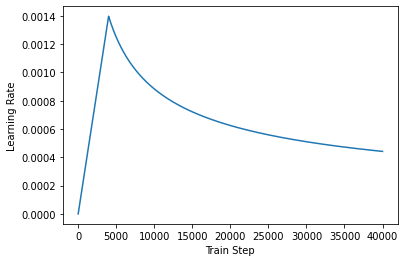

In [13]:
d_model = 128

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [14]:
start_profile_batch = steps+10
stop_profile_batch = start_profile_batch + 100
profile_range = f"{start_profile_batch},{stop_profile_batch}"

log_path = log_dir + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                     update_freq=20,profile_batch=profile_range)

checkpoint_filepath = save_path + "/" + "T5-{epoch:04d}-{val_loss:.4f}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tensorboard_callback, model_checkpoint_callback] 
metrics = [drop_eval.get_metrics]#[tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy') ]

2021-07-13 03:30:56.963185: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-13 03:30:56.963235: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-13 03:30:56.963295: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2021-07-13 03:30:56.964584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64::/usr/local/cuda/lib64:/usr/local/cuda/lib64
2021-07-13 03:30:56.965529: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2021-07-13 03:30:57.155287: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-13 03:30:57.155468: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1

#### Compile and run model

In [15]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
model.compile(optimizer=optimizer)#, metrics=metrics)
model.summary()

Model: "t5for_drop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared (TFSharedEmbeddings)  multiple                  16449536  
_________________________________________________________________
encoder (TFT5MainLayer)      multiple                  18881280  
_________________________________________________________________
decoder (TFT5MainLayer)      multiple                  25175808  
Total params: 60,506,626
Trainable params: 60,506,624
Non-trainable params: 2
_________________________________________________________________


In [16]:
%tensorboard --logdir $log_dir

In [ ]:
if train_model:
    model.fit(tf_train_ds, epochs=epochs, steps_per_epoch=steps, callbacks=callbacks, 
              validation_data=tf_valid_ds, validation_steps=valid_steps,verbose=1)
    if(save_model):
        model.save_pretrained(save_path)
        print('Training complete, model saved')

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-07-13 03:31:39.642035: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-13 03:31:39.825323: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3504000000 Hz


1849/4838 [==========>...................] - ETA: 4:51 - loss: 0.5574 - lr: 3.2318e-04

In [ ]:
if load_model:
    model.load_weights(save_path+'/tf_model.h5')
    print(f'Model loaded from {save_path}')

#### Predict & Evaluate

In [ ]:
def batch_predict(ds,model,tokenizer):
    preds = []

    with tqdm(total=batch_size*len(list(ds.as_numpy_iterator()))) as bar:
        for batch in ds:
            input_ids = batch['input_ids']
            output = model.generate(input_ids)

            for i in range(output.shape[0]):
                single_pred = tokenizer.decode(output[i])
                single_pred = single_pred.replace('<pad>','')
                single_pred = single_pred.replace('</s>','')
                single_pred = single_pred.strip()

                preds.append(single_pred)
                bar.update(1)
    return preds

def evaluate(df):
    EM = []
    F1 = []
    
    
    for predicted,gold in tqdm(zip(df['predicted'],df['answers_spans'])):

        best_EM = 0
        best_F1 = 0

        for potential_answer in gold['spans']:
            metrics = drop_eval.get_metrics(predicted=predicted,gold=potential_answer)

            if metrics[1] > best_F1:
                best_EM = metrics[0]
                best_F1 = metrics[1]

        EM.append(best_EM)
        F1.append(best_F1)
        
    df['EM'] = EM
    df['F1'] = F1
    
    print('Exact Match: {:0.4f}, F1: {:0.4f}'.format(df.EM.mean(),df.F1.mean()))
    return df


In [ ]:
if predict_train:
    print('Making Train Predictions...')
    preds = batch_predict(ds=tf_train_ds,model=model,tokenizer=tokenizer)
    train_df = train_dataset.to_pandas()
    assert len(train_df) == len(preds) "something wen't wrong"
    train_df['predicted'] = preds
    print('Evaluating Train Predictions...')
    train_df = evaluate(train_df)
    if save_results:
        train_df.to_pickle(results_dir+'drop_train'+datetime.datetime.now().strftime('%H%M-%h%d')+'.pkl')
        print('results for predictions on the training data saved to:\n',save_dir)
    
if predict_dev:
    print('Making Dev Predictions...')
    preds = batch_predict(ds=tf_valid_ds,model=model,tokenizer=tokenizer)
    valid_df = valid_dataset.to_pandas()
    valid_df['predicted'] = preds
    print('Evaluating Dev Predictions...')
    valid_df = evaluate(valid_df)
    if save_results:
        valid_df.to_pickle(results_dir+'drop_validation'+datetime.datetime.now().strftime('%H%M-%h%d')+'.pkl')
        print('results for predictions on the validation data saved to:\n',save_dir)    
 

In [ ]:
valid_df.head()

In [ ]:
valid_df[['query_id','passage','question','answers_spans','predicted','EM','F1']].sample(10)

In [ ]:
def print_example(query_id,df):
    print('question: ',df.loc[df.query_id == query_id,'question'].iloc[0])
    print('passage: ',df.loc[df.query_id == query_id,'passage'].iloc[0])
    print('\npredicted answer: ',df.loc[df.query_id == query_id,'predicted'].iloc[0])
    print('True answers: ',df.loc[df.query_id == query_id,'answers_spans'].iloc[0])
    print('F1 score: ',df.loc[df.query_id == query_id,'F1'].iloc[0])
    print('EM score: ',df.loc[df.query_id == query_id,'EM'].iloc[0])
    
    
query_id = '0686d1f9-4a8e-4031-b665-49d425afb777'
print_example(query_id,valid_df)